In [1]:
# /mnt/c/Users/Student/Desktop/Project$ code Alz_Classification/


import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import os 
import random



2024-05-25 04:23:46.612628: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 04:23:46.639998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 04:23:46.640026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 04:23:46.640948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 04:23:46.646598: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 04:23:46.647119: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:


dataset = tf.keras.utils.image_dataset_from_directory(  
    "Alz_Datasets/Alz2/Axial/",
    shuffle = True,
    image_size = (256,170)
)


Found 5154 files belonging to 3 classes.


2024-05-25 04:23:48.965517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 04:23:48.965872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# parameters
batch_size = 16 # Hyperparamter 
image_height = 256
image_width = 170


In [4]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "training", 
    seed = 123, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 4124 files for training.


In [5]:

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "validation",
    seed = 123, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [6]:

class_names = train_dataset.class_names # Identification of class names
print(class_names) 

['AD', 'CI', 'CN']


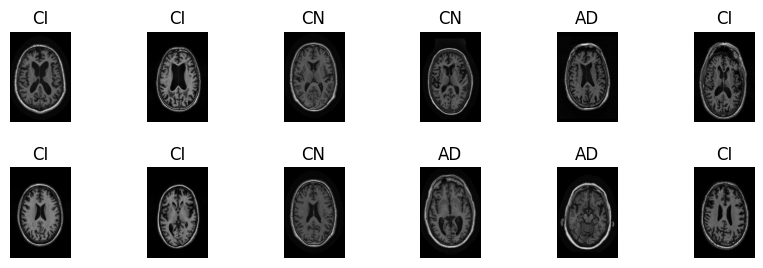

In [7]:
# Plots random 12 brain scans from dataset; just for something viusal
plt.figure(figsize=(10, 10)) # Creates a 10x10 size for the plot
for images, labels in train_dataset.take(1): # The loops the dataset and extracts batches of images with their corresponding labels
    for i in range(12): # Loops 12 times for 12 images
        ax = plt.subplot(6, 6, i + 1) # 6 rows 6 colums and selects current plot loctaion
        plt.imshow(images[i].numpy().astype("uint8")) # Image by converting it to numpy array and specifying its data type as integer unit8
        plt.title(class_names[labels[i]]) # Plots labels 
        plt.axis("off") # Removes Axis

plt.subplots_adjust(wspace=0.5, hspace=0.5) # Spaces images width and height from eachother

plt.show() # displays the plot


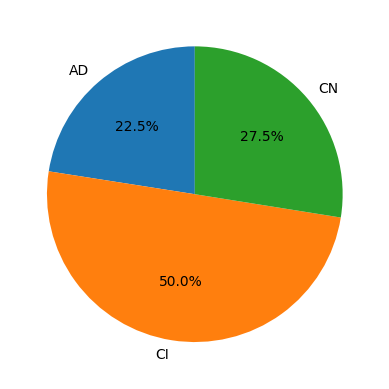

In [8]:

class_counts = [0] * len(class_names) #

for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[label] += 1


plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90) 
#Class Counts:data,labels:Class Names,autopct='%1.1f%%':Format of the percentage display,startangle=90 specifies the angle at which the first slice starts

plt.title("") # Plot Title


plt.show() # Displays the plot

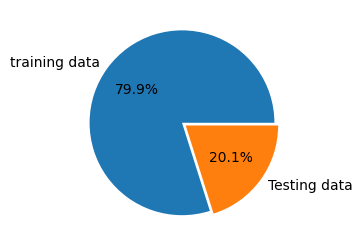

In [9]:
plt.figure(figsize=(3,3))
plt.pie(
    [len(train_dataset), len(validation_dataset)],
    labels=['training data','Testing data'],
    autopct='%.1f%%', explode=(0.05,0),
);

In [10]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 256, 170, 3)
(16,)


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build(input_shape=(None, image_height, image_width, 3))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 170, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 170, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 85, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 85, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 42, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 42, 64)        1

In [14]:
hist = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs= 5
)


Epoch 1/5


/home/jordano/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


258/258 [==============================] - 49s 189ms/step - loss: 0.8578 - accuracy: 0.6135 - val_loss: 0.6070 - val_accuracy: 0.7796
Epoch 2/5
258/258 [==============================] - 49s 191ms/step - loss: 0.4228 - accuracy: 0.8443 - val_loss: 0.3612 - val_accuracy: 0.8621
Epoch 3/5
258/258 [==============================] - 49s 190ms/step - loss: 0.1592 - accuracy: 0.9525 - val_loss: 0.1748 - val_accuracy: 0.9408
Epoch 4/5
258/258 [==============================] - 49s 191ms/step - loss: 0.0549 - accuracy: 0.9903 - val_loss: 0.0930 - val_accuracy: 0.9660
Epoch 5/5
258/258 [==============================] - 50s 193ms/step - loss: 0.0264 - accuracy: 0.9961 - val_loss: 0.0305 - val_accuracy: 0.9932


In [15]:
# tf.keras.models.save_model(
#                             model,
#                            "Model_Alz.h5",
#                            include_optimizer= True ,
#                            save_format= "h5",
#                            )

model.save("model.keras")

In [16]:
model.evaluate(train_dataset)

  1/258 [..............................] - ETA: 9s - loss: 0.0047 - accuracy: 1.0000

258/258 [==============================] - 8s 30ms/step - loss: 0.0133 - accuracy: 0.9993


[0.01331343874335289, 0.9992725253105164]

In [17]:
model.evaluate(validation_dataset)

 1/65 [..............................] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000

65/65 [==============================] - 2s 28ms/step - loss: 0.0305 - accuracy: 0.9932


[0.030493369325995445, 0.99320387840271]

In [18]:

testDataset = ["Alz_Datasets/Alz2/Axial/"]

testPaths = []
testLabels = []

# Iterate over each directory in the test dataset
for testDir in testDataset:
    # Iterate over each label (subdirectory) in the directory
    for label in os.listdir(testDir):
        # Iterate over each image in the label directory
        for image in os.listdir(os.path.join(testDir, label)):
            # Create the full path to the image
            imagePath = os.path.join(testDir, label, image)
            # Append the image path to the testPaths list
            testPaths.append(imagePath)
            # Append the corresponding label to the testLabels list
            testLabels.append(label)

# Shuffle the testPaths and testLabels
testPaths, testLabels = shuffle(testPaths, testLabels)


1/1 [==============================] - 0s 17ms/step


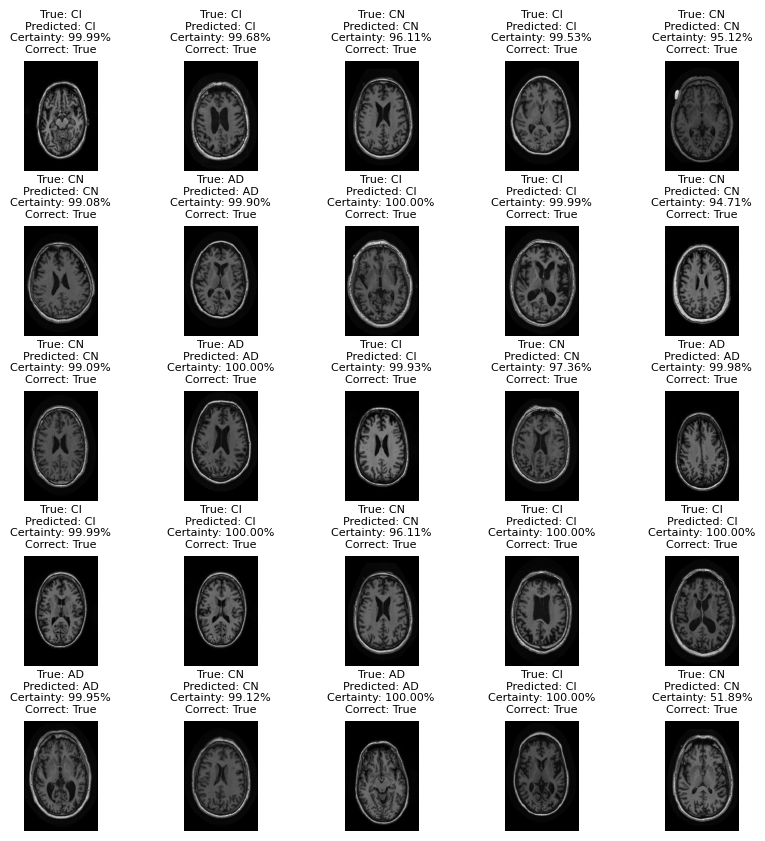

In [19]:


def predictAndPlot(model, paths, labels, n_samples=100):
    # Create a figure for plotting
    plt.figure(figsize=(10, 10))
    
    # Loop over a subset of samples to visualize
    for i in range(min(n_samples, len(paths))):
        # Randomly select an image index
        index = random.randint(0, len(paths)-1)
        # Get the image path and true label
        image_path = paths[index]
        true_label = labels[index]
        
        # Load and resize the image
        image = load_img(image_path, target_size=(image_height, image_width))
        image_array = np.array([(image)])
        
        # Adjust subplots spacing
        plt.subplots_adjust(hspace=0.5)

        # Make predictions on the image
        prediction_probabilities = model.predict(image_array)[0]
        predicted_label_index = np.argmax(prediction_probabilities)
        predicted_label = class_names[predicted_label_index]
        certainty = prediction_probabilities[predicted_label_index] * 100
        correct = true_label == predicted_label

        # Create a subplot for each image
        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        # Set subplot title with prediction details
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%\nCorrect: {correct}', fontsize=8)

predictAndPlot(model, testPaths, testLabels, n_samples=25)
plt.show()


1/1 [==============================] - 0s 55ms/step


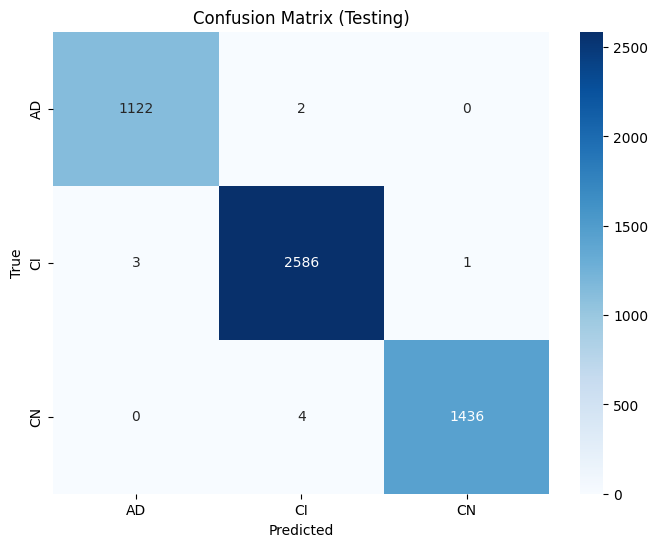

In [20]:

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the dataset and make predictions
for images, labels_batch in dataset:
    predictions_batch = model.predict(images)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(predicted_labels_batch)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=len(class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


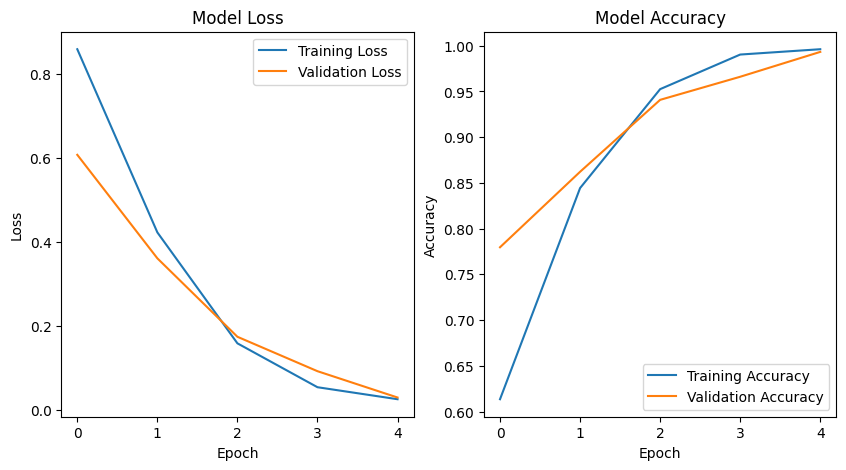

In [21]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()